## Plots and Figures

In [143]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as cl
import matplotlib.patches as mpatches
from cycler import cycler
from matplotlib.colors import TwoSlopeNorm

import joblib
import os

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample
from sklearn.base import clone

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from rdkit import Chem
import numpy as np
import shap

In [144]:
plt.style.use("presentation.mplstyle")
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#5c3c8b', '#92c36d', '#ee9432', '#496391', '#85a5cd', '#FDF3CC'])
plotsize = 5

category_colors = {
    'ROP': "#5c3c8b",
    'ROMP': "#92c36d",
    'cationic': "#ee9432",
    'vinyl/acrylic': "#496391",
    'misc': '#ffffff', 
    'ionic': "#85a5cd",
    'cyclic': "#FDF3CC",
}

state_colors = {
    'l': "#5c3c8b",
    's': "#92c36d",
    'g': "#ee9432",
}

In [145]:
output_dir = "4_images"
model_dir = "3_saved_models"
os.makedirs(output_dir, exist_ok=True)

### Read in previous model training results

In [146]:
direct_ML_results = pd.read_csv(os.path.join('3_images_and_csvs', 'model_results_summary.csv'))
transfer_ML_results = pd.read_csv(os.path.join('3_images_and_csvs', 'transfer_model_results_summary.csv'))

In [147]:
target_names = ['enthalpy', 'entropy', 'tc', 'log_tc', 'tc_transfer']

In [148]:
file_info = {
    "enthalpy": "2_split_datasets/enthalpy_80_MI_reduced.csv",
    "entropy": "2_split_datasets/entropy_80_MI_reduced.csv",
    "tc": "2_split_datasets/has_both_101_MI_reduced.csv",
    "log_tc": "2_split_datasets/has_both_101_MI_reduced.csv", 
}

feature_sets = [
    (name, pd.read_csv(path, index_col=0))
    for name, path in file_info.items()
]

target_idx = 0
phase_split_idx = 1
category_idx = 2
smiles_idx = 3
global_test_idx = 4
first_feature_idx = 5

In [149]:
# add fourth feature set
best_H_model = None
best_S_model = None
best_tc_model = None
best_log_tc_model = None
best_tc_transfer_model = None

for file in os.listdir(model_dir):
    if "enthalpy" in file and "BEST" in file and "chemistry" in file:
        best_H_model = joblib.load(os.path.join(model_dir, file))
        print(file)
    elif "entropy" in file and "BEST" in file and "chemistry" in file:
        best_S_model = joblib.load(os.path.join(model_dir, file))
        print(file)
    elif "tc_transfer" in file and "BEST" in file and "chemistry" in file:
        best_tc_transfer_model = joblib.load(os.path.join(model_dir, file))
        print(file)
    elif "log_tc" in file and "BEST" in file and "chemistry" in file:
        best_tc_transfer_model = joblib.load(os.path.join(model_dir, file))
        print(file)
    elif "tc" in file and "BEST" in file and "chemistry" in file and "transfer" not in file:
        best_tc_model = joblib.load(os.path.join(model_dir, file))
        print(file)

# enthalpy/entropy pred columns
entc = feature_sets[0][1].iloc[:, first_feature_idx:].columns
entrc = feature_sets[1][1].iloc[:, first_feature_idx:].columns

# make predictions
h_preds = best_H_model.predict(feature_sets[2][1].iloc[:, first_feature_idx:][entc])
s_preds = best_S_model.predict(feature_sets[2][1].iloc[:, first_feature_idx:][entrc])

# add to tc data set
tc_df = feature_sets[2][1].copy()
tc_df['predicted_H_TL'] = h_preds
tc_df['predicted_S_TL'] = s_preds
tc_df['predicted_TC_TL'] = h_preds*1000/s_preds - 273.15

feature_sets.append((f"{feature_sets[2][0]}_transfer", tc_df))

log_tc_rf_chemistry_cluster_BEST.joblib
entropy_svr_chemistry_cluster_BEST.joblib
enthalpy_rf_chemistry_cluster_BEST.joblib
tc_transfer_svr_chemistry_cluster_TL_BEST.joblib
tc_xgb_chemistry_cluster_BEST.joblib


### Make Tc Prediction on Global Test Using best H&S models

In [151]:
best_models = {}

for split_type in ['chemistry_cluster']:
    for target_name in target_names:
        # find the model in model_dir that has BEST and the target_name and split_type in its filename
        model_files = [f for f in os.listdir(model_dir) if f.endswith(f"_BEST.joblib") and split_type in f and target_name in f]
        if not model_files:
            continue
        model_file = model_files[0]
        model_path = os.path.join(model_dir, model_file)
        model = joblib.load(model_path)

        # add to best_models dict
        best_models[target_name] = model

In [152]:
feature_info = {
    'enthalpy': feature_sets[0][1],
    'entropy': feature_sets[1][1],
    'tc': feature_sets[2][1],
    'log_tc': feature_sets[3][1],
    'tc_transfer': feature_sets[4][1]
}

In [153]:
results_dfs = []

# re-make predictions, save them this time
for target_name, dataframe in feature_sets:
    if target_name in target_names:
        # Filter to only global test set
        dataframe = dataframe[dataframe['Global_Test'] == True]

        X = dataframe.iloc[:, first_feature_idx:]
        y = dataframe.iloc[:, target_idx]
        phase = dataframe['BASE_Monomer_State']
        smiles = dataframe['Canonical SMILES']
        category = dataframe.iloc[:, category_idx]

        preds = best_models[target_name].predict(X[best_models[target_name].feature_names_in_])
        residuals = preds - y

        temp_df = pd.DataFrame({
            f'smiles_{target_name}': smiles,
            f'phase_{target_name}': phase,
            f'category_{target_name}': category,
            f'predicted_{target_name}': preds,
            f'actual_{target_name}': y,
            f'residual_{target_name}': residuals,
        })
        
        results_dfs.append(temp_df)

### Make plots comparing all valid results

In [154]:
# add to results_dfs
temp = results_dfs[4].copy()

temp.columns = [col.replace('tc_transfer', 'tc_indirect') for col in temp.columns]
temp.columns = [col.replace('tc_transfer', 'tc_indirect') for col in temp.columns]

temp['predicted_tc_indirect'] = 0
temp['residual_tc_indirect']  = 0

temp['predicted_tc_indirect'] = results_dfs[0]['predicted_enthalpy'] * 1000 / results_dfs[1]['predicted_entropy'] - 273.15
temp['residual_tc_indirect']  = temp['predicted_tc_indirect'] - temp['actual_tc_indirect']

results_dfs.append(temp)
target_names.append('tc_indirect')

In [155]:
unit_dict = {
    "enthalpy": r"$\Delta H_P$ (kcal/mol)",
    "entropy": r"$\Delta S_P$ (cal/mol/K)",
    "tc": r"$T_C$ (°C)",
    "log_tc": r"$T_C$ (log) (°C)",
    "tc_indirect": r"$T_C$ (Eqn.) (°C)",
    "tc_transfer": r"$T_C$ (TL) (°C)",
}

In [156]:
combined_df = pd.concat(results_dfs, axis=1)

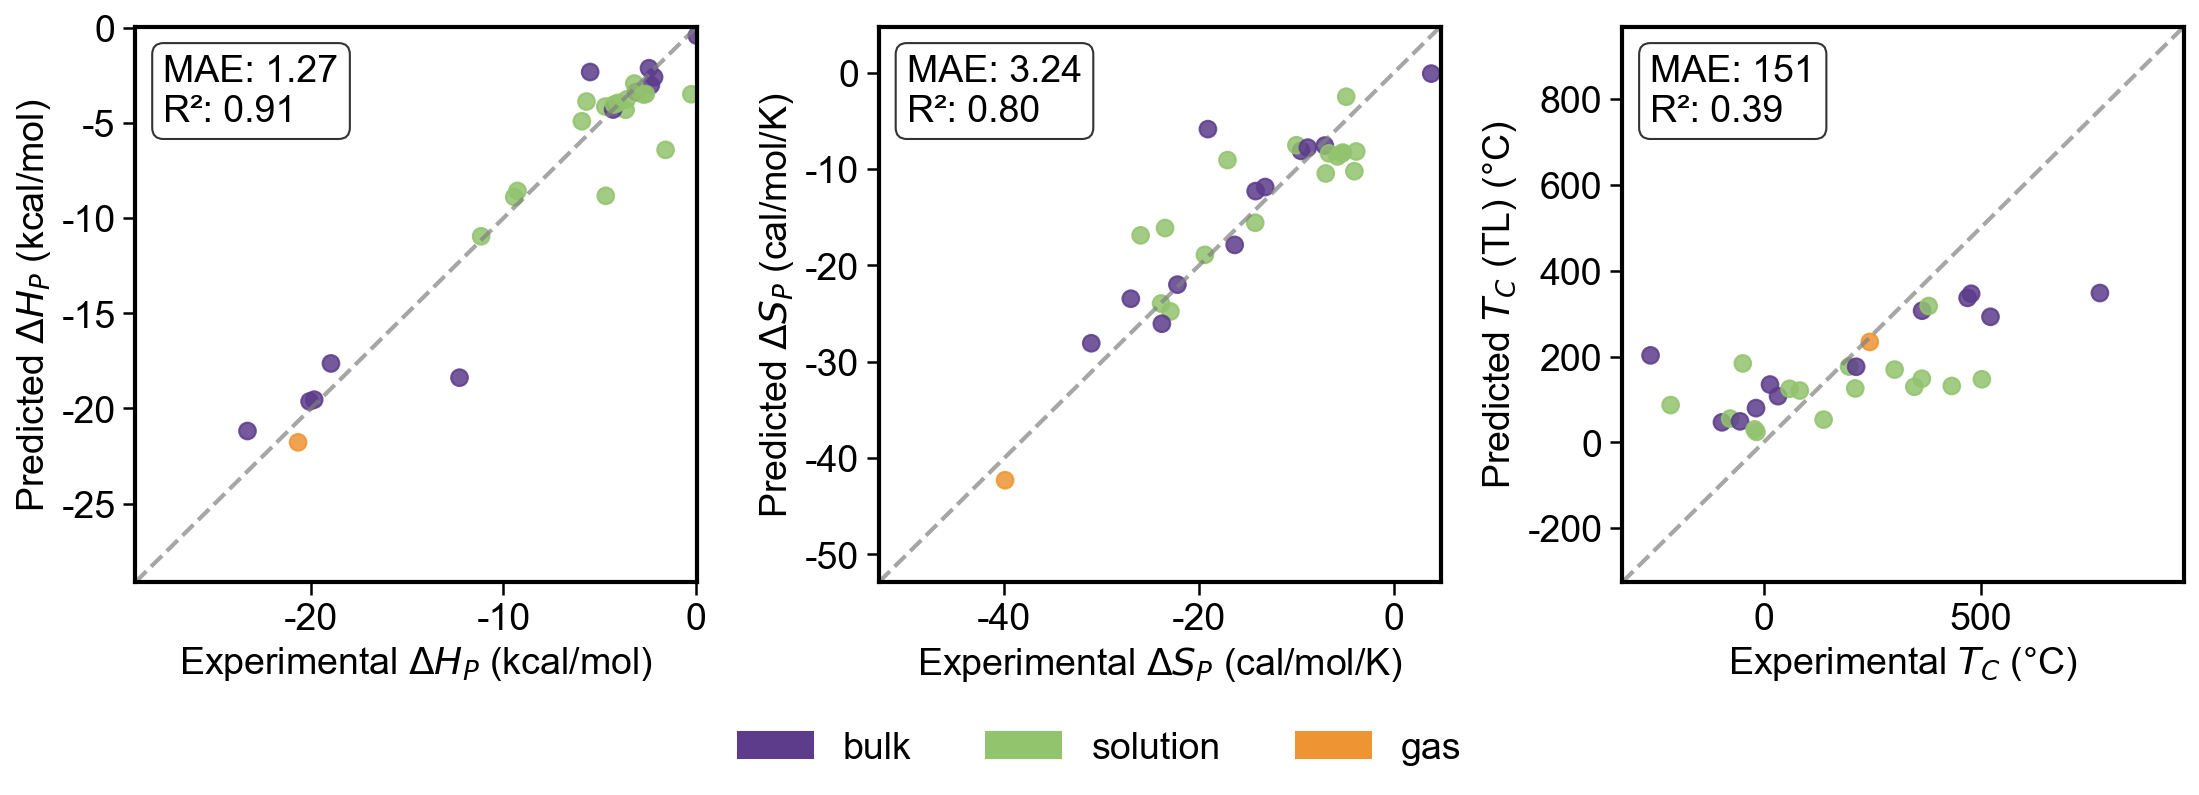

In [157]:
# Map phase codes to descriptive names for legend
phase_labels = {'l': 'bulk', 's': 'solution', 'g': 'gas'}

# check which ones to plot firs
plot_targets = []
plot_dfs = []
for df, target_name in zip(results_dfs, target_names):
    mae_direct = mean_absolute_error(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    r2_direct = r2_score(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    
    # only plot valid R2 scores
    if r2_direct > 0 and r2_direct < 1:
        plot_dfs.append(df)
        plot_targets.append(target_name)

fig, axes = plt.subplots(1, len(plot_targets), figsize=(len(plot_targets)*plotsize, plotsize), sharex=False, sharey=False)

for ax, df, target_name in zip(axes, plot_dfs, plot_targets):
    phase_col = f'phase_{target_name}'
    color_vals = df[phase_col].map(state_colors)
    ax.scatter(df[f'actual_{target_name}'], df[f'predicted_{target_name}'], c=color_vals, alpha=0.85)
    min_val = min(df[f'actual_{target_name}'].min(), df[f'predicted_{target_name}'].min()) * 1.25
    max_val = max(df[f'actual_{target_name}'].max(), df[f'predicted_{target_name}'].max())
    if max_val < 0:
        max_val *= 0.75
    else:
        max_val *= 1.25

    ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray', alpha=0.7)
    if "T" in unit_dict[target_name]:
        ax.set_xlabel(r'Experimental $T_C$ (°C)')
        ax.set_ylabel('Predicted ' + unit_dict[target_name])
    else:
        ax.set_xlabel('Experimental ' + unit_dict[target_name])
        ax.set_ylabel('Predicted ' + unit_dict[target_name])
    # ax.set_title(f'{target_name.replace('_transfer', ' Transfer').capitalize()}')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.tick_params(axis='both', which='major')

    # round axes labels to integers for all
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}'))

    mae_direct = mean_absolute_error(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    r2_direct = r2_score(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    
    if "tc" in target_name:
        ax.text(0.05, 0.95, f'MAE: {mae_direct:.0f}\nR²: {r2_direct:.2f}', transform=ax.transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.05, 0.95, f'MAE: {mae_direct:.2f}\nR²: {r2_direct:.2f}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Create legend handles for phase colors with descriptive labels
handles = [mpatches.Patch(color=color, label=phase_labels[phase]) for phase, color in state_colors.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(state_colors), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.savefig(f'{output_dir}/model_parity.png', dpi=300)
plt.show()

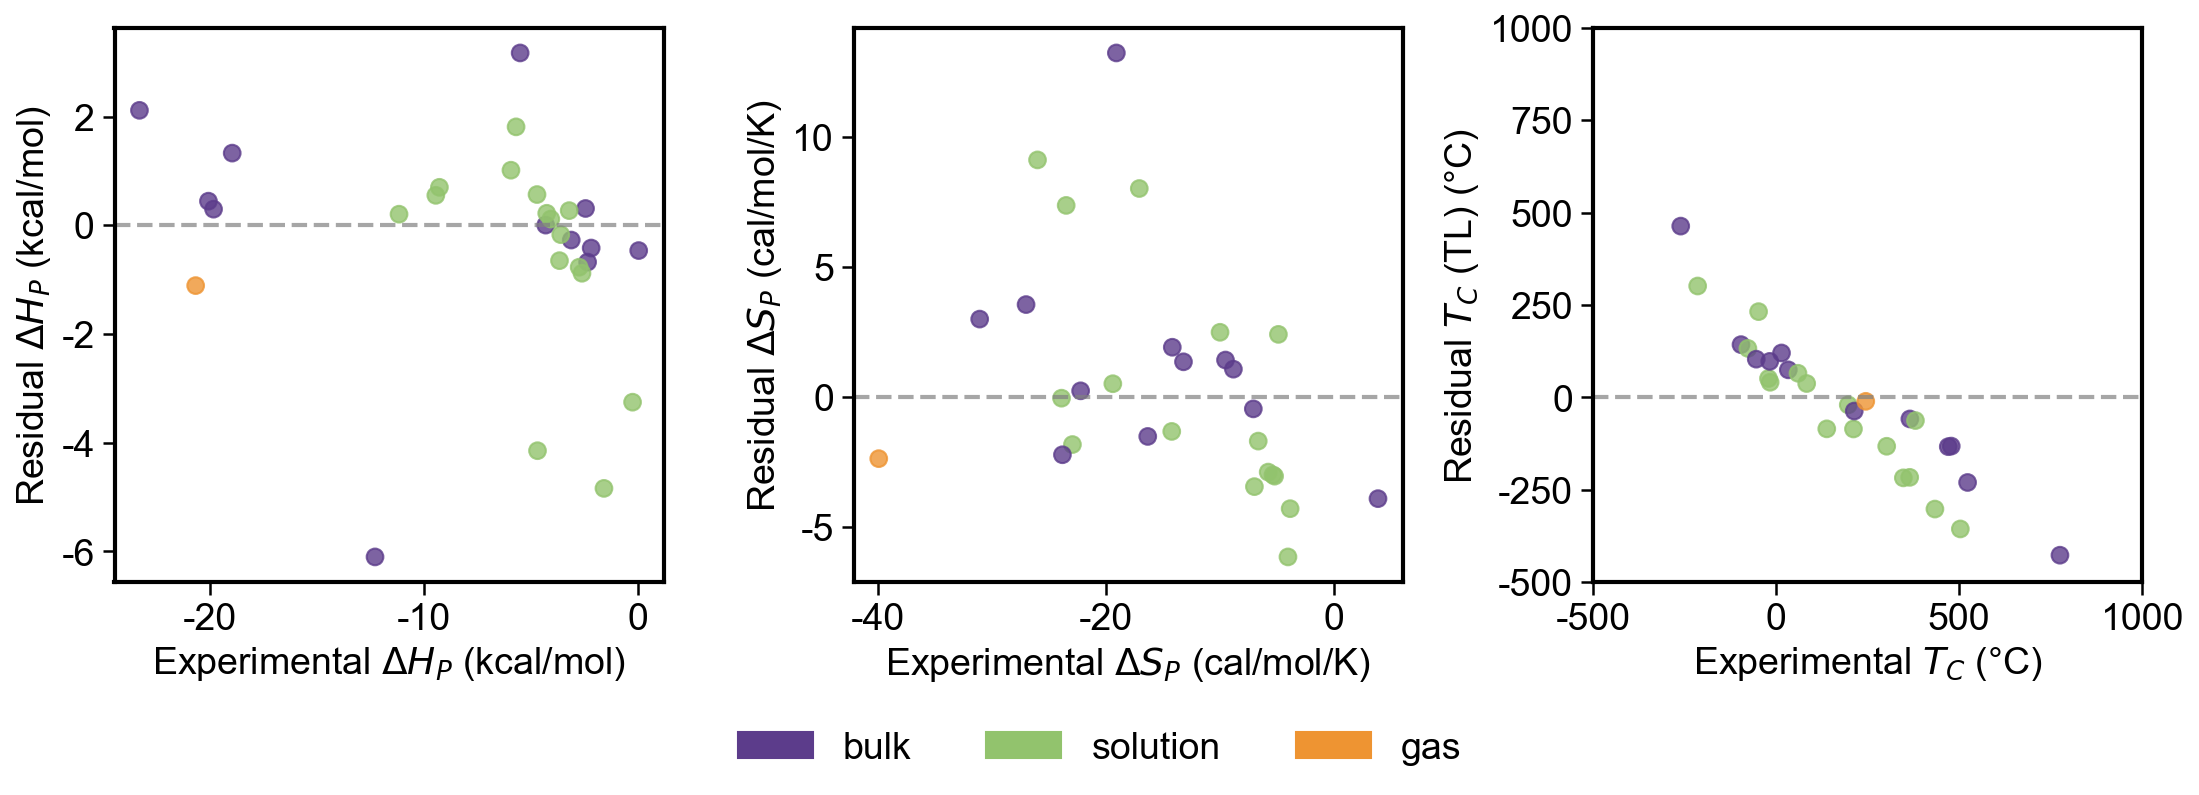

In [158]:
# Map phase codes to descriptive names for legend
phase_labels = {'l': 'bulk', 's': 'solution', 'g': 'gas'}

# check which ones to plot firs
plot_targets = []
plot_dfs = []
for df, target_name in zip(results_dfs, target_names):
    mae_direct = mean_absolute_error(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    r2_direct = r2_score(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    
    # only plot valid R2 scores
    if r2_direct > 0 and r2_direct < 1:
        plot_dfs.append(df)
        plot_targets.append(target_name)

fig, axes = plt.subplots(1, len(plot_targets), figsize=(len(plot_targets)*plotsize, plotsize), sharex=False, sharey=False)

for ax, df, target_name in zip(axes, plot_dfs, plot_targets):
    phase_col = f'phase_{target_name}'
    color_vals = df[phase_col].map(state_colors)
    residuals = df[f'predicted_{target_name}'] - df[f'actual_{target_name}']
    ax.scatter(df[f'actual_{target_name}'], residuals, c=color_vals, alpha=0.8)
    ax.axhline(0, linestyle='--', color='gray', alpha=0.7)

    if "T" in unit_dict[target_name]:
        ax.set_xlabel(r'Experimental $T_C$ (°C)')
        ax.set_ylabel('Residual ' + unit_dict[target_name])
        ax.set_ylim([-500,1000])
        ax.set_xlim([-500,1000])
    else:
        ax.set_xlabel('Experimental ' + unit_dict[target_name])
        ax.set_ylabel('Residual ' + unit_dict[target_name])

    target_name = target_name.replace('_transfer', ' Transfer')
    ax.tick_params(axis='both', which='major')

    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}'))


# Create legend handles for phase colors with descriptive labels
handles = [mpatches.Patch(color=color, label=phase_labels[phase]) for phase, color in state_colors.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(state_colors), bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.savefig(f'{output_dir}/residuals.png', dpi=300)
plt.show()


### Compare indirect prediction

In [159]:
plot_targets

['enthalpy', 'entropy', 'tc_transfer']

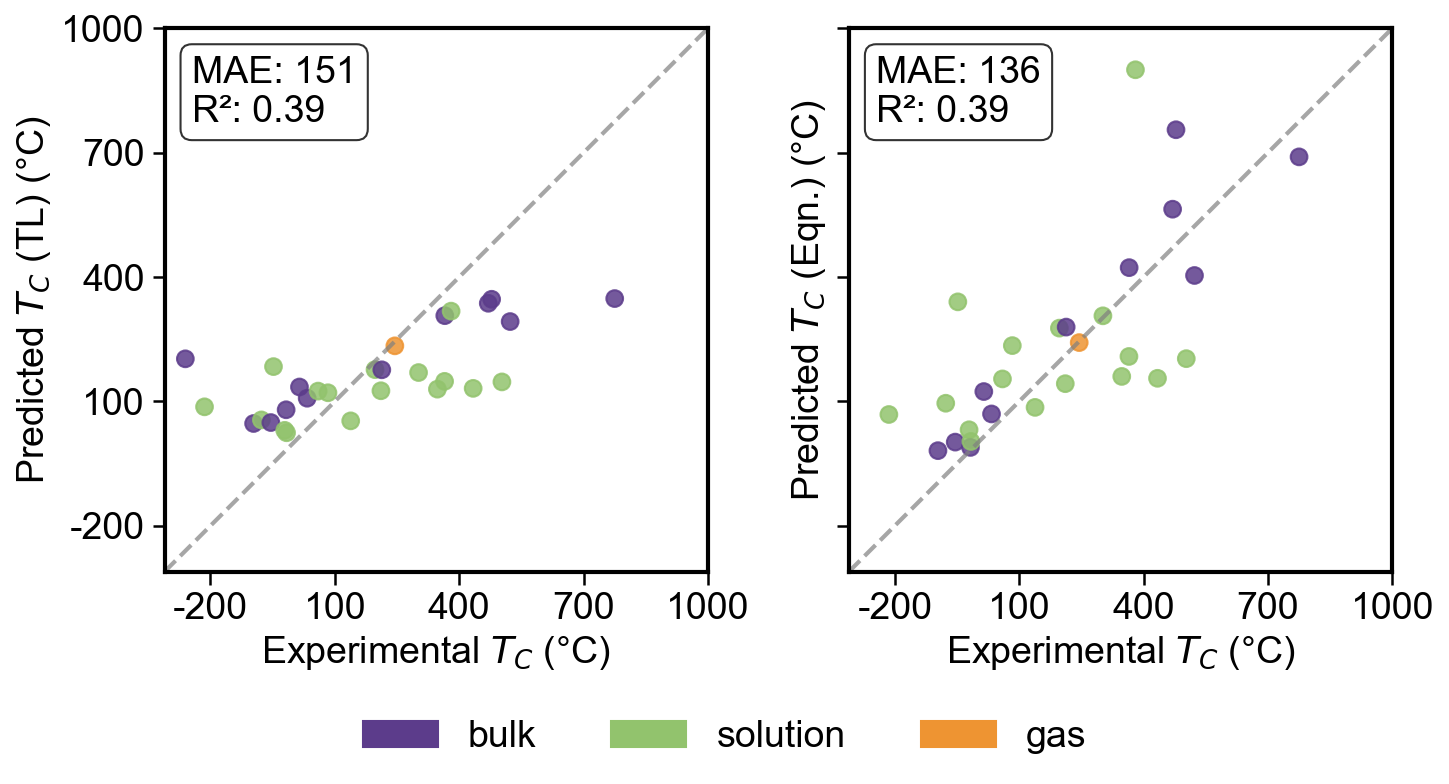

In [ ]:
# Map phase codes to descriptive names for legend
phase_labels = {'l': 'bulk', 's': 'solution', 'g': 'gas'}

# check which ones to plot first
plot_targets = []
plot_dfs = []
for df, target_name in zip(results_dfs[-4:], target_names[-4:]):
    if "tc_indirect" in target_name:
        df = df[(results_dfs[0]['actual_enthalpy'] < 0) & (results_dfs[1]['actual_entropy'] < 0)]
    mae_direct = mean_absolute_error(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    r2_direct = r2_score(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    # only plot valid R2 scores
    if r2_direct > 0 and r2_direct < 1:
        plot_dfs.append(df)
        plot_targets.append(target_name)

# Calculate global min/max across dataframes
global_min = float('inf')
global_max = float('-inf')
for df, target_name in zip(plot_dfs, plot_targets):
    global_min = min(global_min, df[f'actual_{target_name}'].min(), df[f'predicted_{target_name}'].min())
    global_max = max(global_max, df[f'actual_{target_name}'].max(), df[f'predicted_{target_name}'].max())

min_val = global_min -50
max_val = global_max +50

fig, axes = plt.subplots(1, len(plot_targets), figsize=(len(plot_targets)*plotsize, plotsize), sharex=True, sharey=True)

tick_locations = np.linspace(-200, 1000, 5) 

for ax, df, target_name in zip(axes, plot_dfs, plot_targets):
    phase_col = f'phase_{target_name}'
    color_vals = df[phase_col].map(state_colors)
    ax.scatter(df[f'actual_{target_name}'], df[f'predicted_{target_name}'], c=color_vals, alpha=0.85)
    
    ax.plot([min_val, max_val*1.5], [min_val, max_val*1.5], '--', color='gray', alpha=0.7)
    ax.set_xlabel(r'Experimental $T_C$ (°C)')
    ax.set_ylabel('Predicted ' + unit_dict[target_name])
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.tick_params(axis='both', which='major')
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}'))
    
    mae_direct = mean_absolute_error(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    r2_direct = r2_score(df[f'actual_{target_name}'], df[f'predicted_{target_name}'])
    if "tc" in target_name:
        ax.text(0.05, 0.95, f'MAE: {mae_direct:.0f}\nR²: {r2_direct:.2f}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.05, 0.95, f'MAE: {mae_direct:.2f}\nR²: {r2_direct:.2f}', transform=ax.transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.set_aspect('equal')
    ax.set_xticks(tick_locations)
    ax.set_yticks(tick_locations)
    

handles = [mpatches.Patch(color=color, label=phase_labels[phase]) for phase, color in state_colors.items()]
fig.legend(handles=handles, loc='lower center', ncol=len(state_colors), bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.savefig(f'{output_dir}/tc_parity_valid.png', dpi=300)
plt.show()

In [161]:
# Setting colormap for all error plotting
dark_blue = "#364a6c"
dark_blue_h = "#899fc4"
med_blue = "#4979b2"
med_blue_h = "#85a5cd"
white = "#ffffff"
green = "#6ba142"
green_h = "#92c36d"

pos_colormap = cl.LinearSegmentedColormap.from_list("", [white, dark_blue_h, dark_blue])
pos_neg_cmap = cl.LinearSegmentedColormap.from_list(
    "", [white, green, green_h, med_blue_h, med_blue]
)
pos_colormap = cl.LinearSegmentedColormap.from_list("", ['#5c3c8b', '#85a5cd','#92c36d',  "#fff67a76"])

/var/folders/ss/dmsyhg291_ldxc23t146pcq40000gn/T/ipykernel_39060/1577263981.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


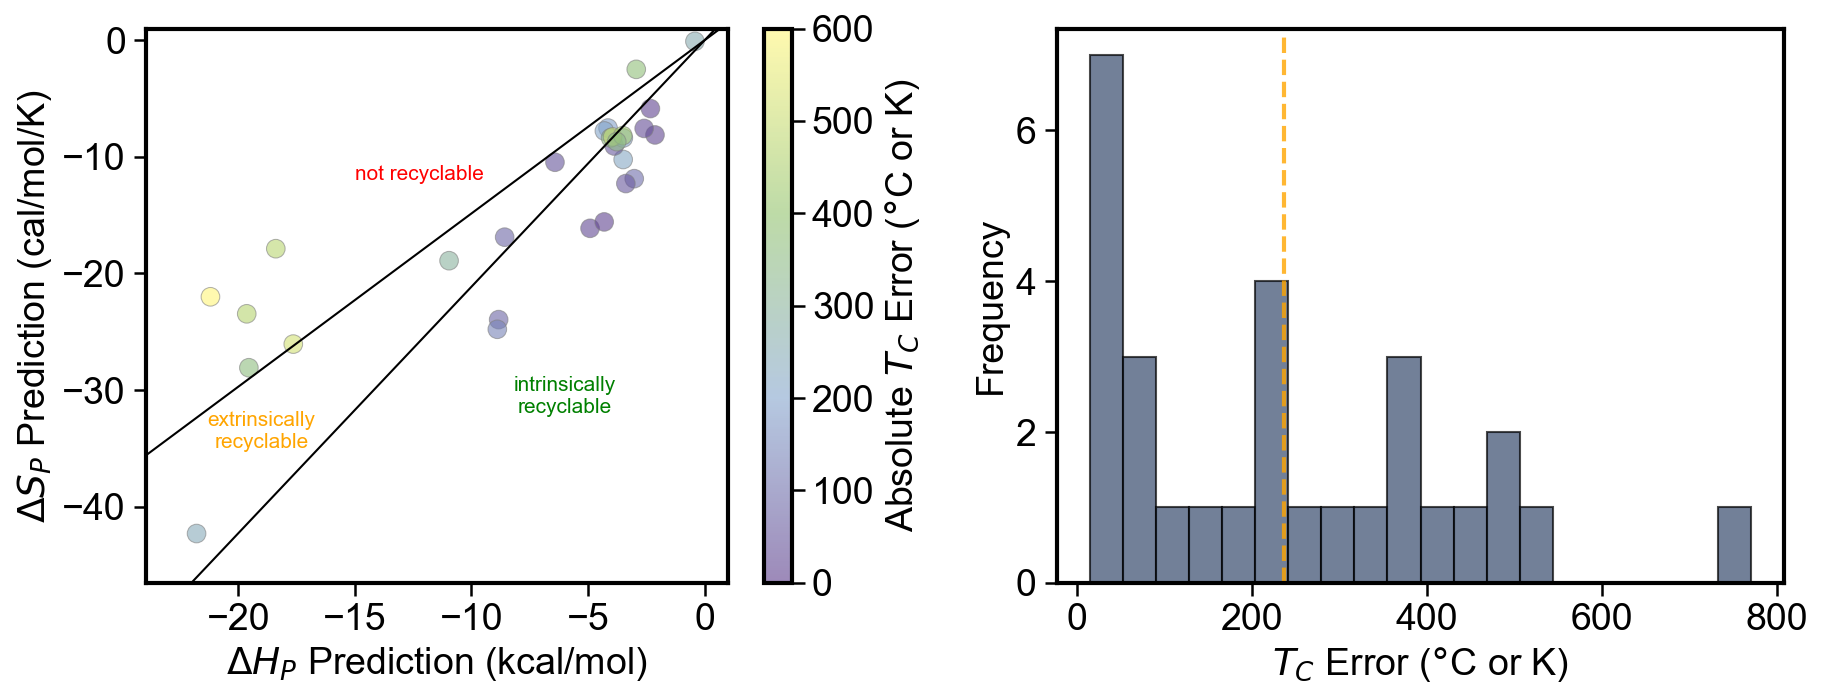

In [162]:
# h_pred, s_pred, tc_actual, tc_pred from test set
merged_df = pd.concat(results_dfs, axis=1)
tc_error = merged_df['predicted_tc'] - merged_df['actual_tc']  # Signed error
tc_abs_error = np.abs(tc_error)  # Absolute error

def plot_comprehensive_tc_error_analysis(h_pred, s_pred, tc_actual, tc_pred, phases=None, functional_groups=None):
    """
    Comprehensive error analysis with multiple views
    """
    tc_error = abs(tc_pred - tc_actual)
    
    fig, axes = plt.subplots(1, 2, figsize=(plotsize*2.5, plotsize))
    
    scatter1 = axes[0].scatter(h_pred, s_pred, c=tc_error, cmap=pos_colormap, 
                                s=80, edgecolors='gray', linewidth=0.5, alpha=0.6, vmin=0, vmax=600)
    cbar1 = plt.colorbar(scatter1, ax=axes[0])
    cbar1.set_label(r'Absolute $T_C$ Error ($\degree$C or K)')
    ticks = np.linspace(0, 600, 7)
    cbar1.set_ticks(ticks)

    axes[0].set_xlabel(r'$\Delta H_P$' + ' Prediction (kcal/mol)')
    axes[0].set_ylabel(r'$\Delta S_P$' + ' Prediction (cal/mol/K)')

    ax = axes[0]
    x_1 = 10
    x_2 = -28
    S_y_1_200 = (1000 * x_1)/(200+273)
    S_y_1_400 = (1000 * x_1)/(400+273)
    S_y_2_200 = (1000 * x_2)/(200+273)
    S_y_2_400 = (1000 * x_2)/(400+273)

    ax.plot([x_1, x_2], [S_y_1_200, S_y_2_200], color="black", lw=1)
    ax.plot([x_1, x_2], [S_y_1_400, S_y_2_400], color="black", lw=1)

    ax.set_xlim(h_pred.min()*1.1, 1)
    ax.set_ylim(s_pred.min()*1.1, 1)
    ax.set_aspect('auto')

    ax.text(-15,-12,"not recyclable", fontsize=10, c='red')
    ax.text(-6,-32,"intrinsically\nrecyclable", fontsize=10, horizontalalignment='center', c='green')
    ax.text(-19,-35,"extrinsically\nrecyclable", horizontalalignment='center', fontsize=10, c='orange')
    
    axes[1].hist(tc_error, bins=20, alpha=0.7, color=dark_blue, edgecolor='black')
    axes[1].axvline(x=np.mean(tc_error), color='orange', linestyle='--', alpha=0.8,)
    axes[1].set_xlabel(r'$T_C$ Error ($\degree$C or K)')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{output_dir}/tc_design_space_model_error.png", dpi=300, bbox_inches='tight')
    plt.show()

h_pred = merged_df['predicted_enthalpy'].values
s_pred = merged_df['predicted_entropy'].values
tc_actual = merged_df['actual_tc'].values
tc_pred = merged_df['predicted_tc'].values

plot_comprehensive_tc_error_analysis(h_pred, s_pred, tc_actual, tc_pred)

### Look deeper at errors: by molecule/functional group/phase

In [163]:
# assert that all columns that contain 'smiles' are identical
smiles_cols = [col for col in merged_df.columns if 'smiles' in col]
for i in range(1, len(smiles_cols)):
    assert all(merged_df[smiles_cols[0]] == merged_df[smiles_cols[i]]), "SMILES columns do not match!"

smiles_cols = [col for col in merged_df.columns if 'phase' in col]
for i in range(1, len(smiles_cols)):
    assert all(merged_df[smiles_cols[0]] == merged_df[smiles_cols[i]]), "SMILES columns do not match!"

In [164]:
for target in target_names:
    merged_df[f'{target}_error'] = merged_df[f'predicted_{target}'] - merged_df[f'actual_{target}']
    merged_df[f'{target}_abs_error'] = merged_df[f'{target}_error'].abs()

In [165]:
phase_error = merged_df.groupby('phase_enthalpy')[
    ['enthalpy_abs_error', 'entropy_abs_error', 'tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error']
].mean().sort_values(by=['enthalpy_abs_error','entropy_abs_error','tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error'], ascending=False)

print("\nPhase-level errors:")
print(phase_error)

phase_error = phase_error.reset_index()


Phase-level errors:
                enthalpy_abs_error  entropy_abs_error  tc_abs_error  \
phase_enthalpy                                                        
l                         1.299718           2.822262    271.607757   
s                         1.260282           3.608267    209.566390   
g                         1.110786           2.385334    239.166431   

                tc_transfer_abs_error  tc_indirect_abs_error  
phase_enthalpy                                                
l                          168.282740             424.897267  
s                          146.199604             175.502072  
g                           10.807045               2.949135  


In [166]:
state_colors_tmp = {'l': '#5c3c8b', 's': '#BBA8D9', 'g': '#BFABDC'}

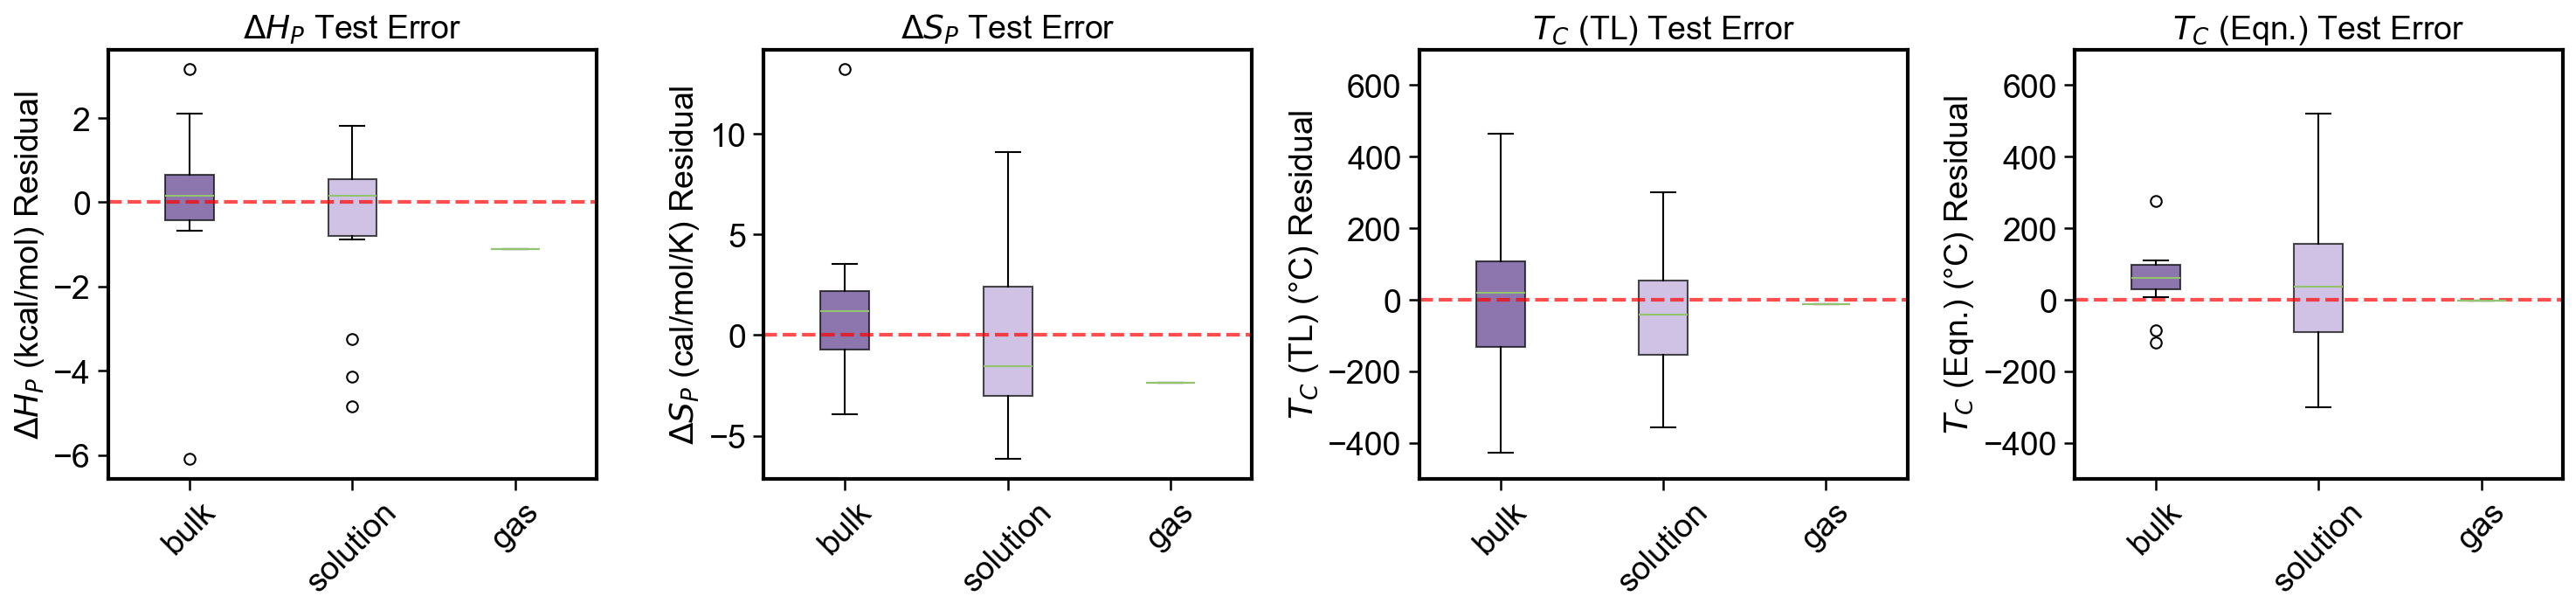

In [175]:
targets = [
    ('enthalpy', r'$\Delta H_P$'),
    ('entropy', r'$\Delta S_P$'), 
    ('tc_transfer', r'$T_C$ (TL)'),
    ('tc_indirect', r'$T_C$ (Eqn.)')
]

fig, axes = plt.subplots(1, len(targets), figsize=(plotsize*len(targets), plotsize))

for i, (target, label) in enumerate(targets):
    ax = axes[i]
    
    # Create box plot data
    phases = ['l', 's', 'g']
    phases_full = ['bulk', 'solution', 'gas']
    box_data = [merged_df[merged_df['phase_enthalpy'] == phase][f'{target}_error'] for phase in phases]
    bp = ax.boxplot(box_data, tick_labels=phases_full, patch_artist=True)

    # tc plots need same axes
    if "tc" in target:
        ax.set_ylim([-500,700])
    
    for patch, phase in zip(bp['boxes'], phases):
        if phase in state_colors_tmp:
            patch.set_facecolor(state_colors_tmp[phase])
            patch.set_alpha(0.7)
    
    ax.set_title(f'{label} Test Error')
    ax.set_ylabel(unit_dict[target] + " Residual")
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)  # Reference line at zero
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"{output_dir}/errors_and_residuals_by_phase.png", dpi=300, bbox_inches='tight')
plt.show()


In [176]:
smiles_cols = {
    'enthalpy': 'smiles_enthalpy',
    'entropy': 'smiles_enthalpy',
    'tc': 'smiles_enthalpy',
    'tc_indirect': 'smiles_enthalpy',
}

# Average absolute error by SMILES (for enthalpy target)
smiles_error = merged_df.groupby(smiles_cols['enthalpy'])[
    ['enthalpy_abs_error','entropy_abs_error','tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error']
].mean().sort_values(by=['enthalpy_abs_error','entropy_abs_error','tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error'], ascending=False)

print("Molecules that are consistently hard to predict:")
print(smiles_error.head(5))

Molecules that are consistently hard to predict:
                          enthalpy_abs_error  entropy_abs_error  tc_abs_error  \
smiles_enthalpy                                                                 
C1COC1                              6.102458           1.530336    472.301970   
C1=CC2C(C1)C1CC2C2SSSC12            4.841562           3.462709     46.662888   
O=CC(Br)(Br)Br                      4.148224           0.057736     75.682268   
C1=CCCCC1                           3.255627           6.168738    219.006439   
O=S1(=O)CCCO1                       3.169437          13.232616     14.733273   

                          tc_transfer_abs_error  tc_indirect_abs_error  
smiles_enthalpy                                                         
C1COC1                               131.967257             277.009025  
C1=CC2C(C1)C1CC2C2SSSC12             231.897418             388.105496  
O=CC(Br)(Br)Br                       132.461856             172.667892  
C1=CCCCC1         

In [177]:
def get_functional_groups(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return []

    patterns = {
        'alcohol': Chem.MolFromSmarts('[OX2H]'),
        'amine': Chem.MolFromSmarts('[NX3;H2,H1;!$(NC=O)]'),
        'carbonyl': Chem.MolFromSmarts('[CX3]=[OX1]'),
        'halogen': Chem.MolFromSmarts('[F,Cl,Br,I]'),
        'aromatic': Chem.MolFromSmarts('a'),
    }
    found = []
    for name, patt in patterns.items():
        if mol.HasSubstructMatch(patt):
            found.append(name)
    return found

merged_df['functional_groups'] = merged_df['smiles_enthalpy'].apply(get_functional_groups)
df_fg = merged_df.explode('functional_groups')

fg_error = df_fg.groupby('functional_groups')[
    ['enthalpy_abs_error','entropy_abs_error','tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error']
].mean().sort_values(by=['enthalpy_abs_error','entropy_abs_error','tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error'], ascending=False)

print("\nFunctional groups with highest average error:")
print(fg_error)


Functional groups with highest average error:
                   enthalpy_abs_error  entropy_abs_error  tc_abs_error  \
functional_groups                                                        
halogen                      4.148224           0.057736     75.682268   
carbonyl                     0.874506           3.370903    225.635099   
aromatic                     0.600737           1.589626     75.292117   

                   tc_transfer_abs_error  tc_indirect_abs_error  
functional_groups                                                
halogen                       132.461856             172.667892  
carbonyl                      165.499317             388.170579  
aromatic                       63.039898              36.273767  


In [178]:
fg_colors = {
    'amine': "#92c36d",

    'carbonyl': "#496391",
    'aromatic': "#889FC5",
    'halogen': "#B0BFD8",    
    'alcohol': "#D7DFEB",
    
    'cyclic': "#FDF3CC",
}

fg_error = df_fg.groupby('functional_groups')[
    ['enthalpy_abs_error','entropy_abs_error','tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error']
].mean().reset_index()

fg_error['color'] = fg_error['functional_groups'].map(fg_colors)

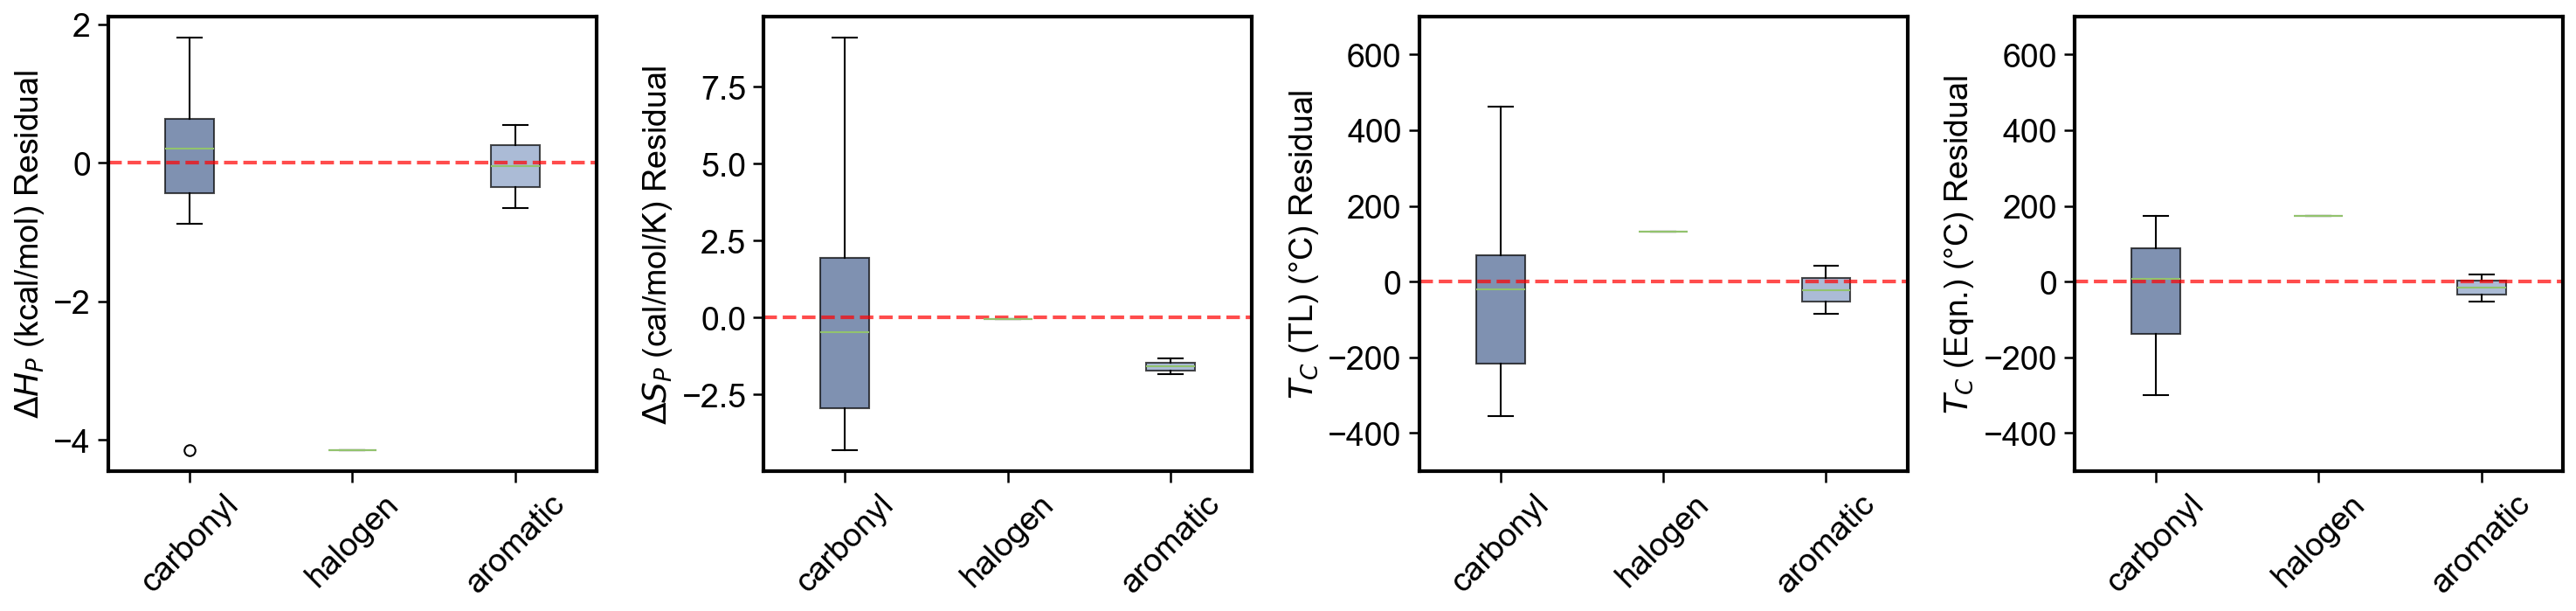

In [179]:
fig, axes = plt.subplots(1, len(targets), figsize=(plotsize*len(targets), plotsize))
target_names = [tup[0] for tup in targets]

for i, (target, label) in enumerate(zip(target_names, [name[1] for name in targets])):
    ax = axes[i]
    
    functional_groups = df_fg['functional_groups'].unique()
    box_data = []
    box_labels = []
    colors_for_boxes = []
    
    for fg in functional_groups:
        fg_data = df_fg[df_fg['functional_groups'] == fg][f'{target}_error']
        if len(fg_data) > 0:  # Only include groups with data
            box_data.append(fg_data)
            box_labels.append(fg)
            colors_for_boxes.append(fg_colors.get(fg, 'gray'))
    
    bp = ax.boxplot(box_data, tick_labels=box_labels, patch_artist=True)

    # tc plots need same axes
    if "tc" in target:
        ax.set_ylim([-500,700])
    
    for patch, color in zip(bp['boxes'], colors_for_boxes):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_ylabel(unit_dict[target] + " Residual")
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)  # Reference line at zero
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(f"{output_dir}/errors_and_residuals_by_func_grp.png", dpi=300, bbox_inches='tight')
plt.show()

In [180]:
cat_error = merged_df.groupby('category_enthalpy')[
    ['enthalpy_abs_error', 'entropy_abs_error', 'tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error']
].mean().sort_values(by=['enthalpy_abs_error','entropy_abs_error','tc_abs_error', 'tc_transfer_abs_error', 'tc_indirect_abs_error'], ascending=False)

print("\nCategory-level errors:")
print(cat_error)

cat_error = cat_error.reset_index()


Category-level errors:
                   enthalpy_abs_error  entropy_abs_error  tc_abs_error  \
category_enthalpy                                                        
ionic                        4.148224           0.057736     75.682268   
cationic                     2.291665           1.250424    347.381222   
ROMP                         1.803965           2.885367    172.917191   
ROP                          0.825983           4.324102    202.282145   
vinyl/acrylic                0.660773           3.229893    299.191843   

                   tc_transfer_abs_error  tc_indirect_abs_error  
category_enthalpy                                                
ionic                         132.461856             172.667892  
cationic                      201.245536             123.878182  
ROMP                          134.763194             255.210895  
ROP                           172.495236             457.010854  
vinyl/acrylic                  98.312969              68.7691

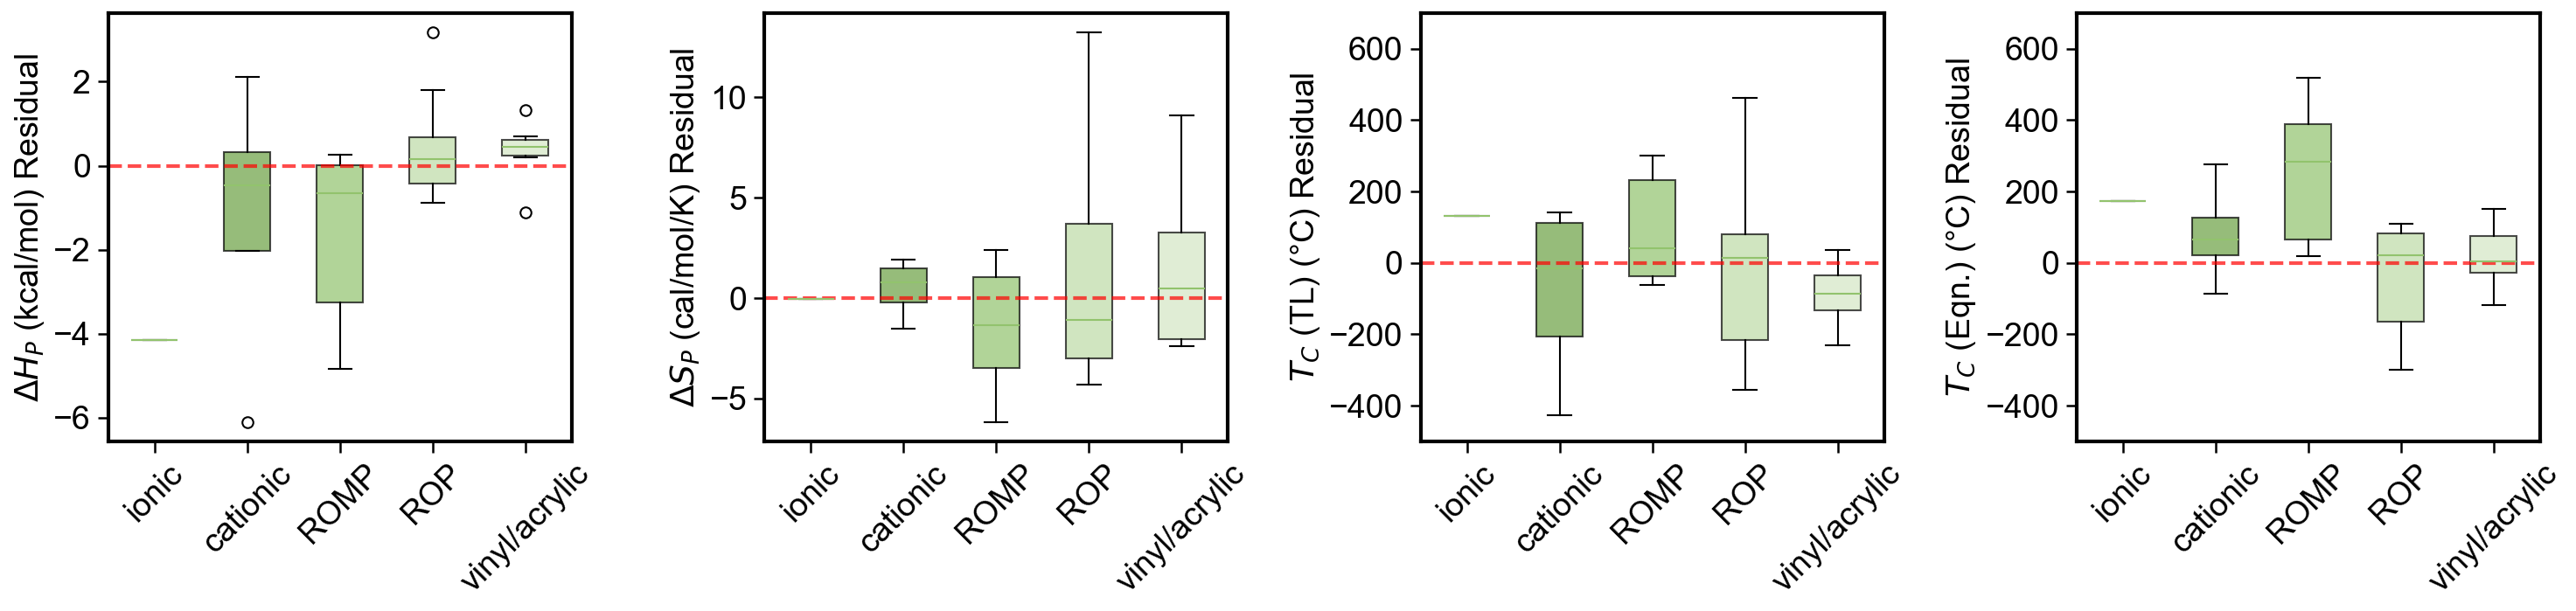

In [181]:
targets = [
    ('enthalpy', 'ΔH'),
    ('entropy', 'ΔS'), 
    ('tc_transfer', 'Tc TL'),
    ('tc_indirect', 'Tc Indirect')
]

category_colors = {
    'cationic': "#6AA042",
    'ROMP': "#91C26C",
    'ROP': "#BCDAA6",
    'vinyl/acrylic': "#D3E6C4",
    'ionic': "#E9F2E1",

    'misc': '#ffffff',
    'cyclic': "#FDF3CC",
}

fig, axes = plt.subplots(1, len(targets), figsize=(plotsize*len(targets), plotsize))

# Bottom row: Box plots of residuals (signed errors)
for i, (target, label) in enumerate(targets):
    ax = axes[i]
    
    # Create box plot data
    cats = cat_error['category_enthalpy'].tolist()
    box_data = [merged_df[merged_df['category_enthalpy'] == cat][f'{target}_error'] for cat in cats]
    
    # Box plot
    bp = ax.boxplot(box_data, tick_labels=cats, patch_artist=True)

    # tc plots need same axes
    if "tc" in target:
        ax.set_ylim([-500,700])
    
    for patch, cat in zip(bp['boxes'], cats):
        if cat in category_colors:
            patch.set_facecolor(category_colors[cat])
            patch.set_alpha(0.7)

    ax.set_ylabel(unit_dict[target] + " Residual")
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.7)  # Reference line at zero
    ax.tick_params(axis='x', rotation=45)

# fig.suptitle("Prediction Errors by Phase: Magnitude and Distribution")
plt.tight_layout()
plt.savefig(f"{output_dir}/errors_and_residuals_by_category.png", dpi=300, bbox_inches='tight')
plt.show()


### Look at SHAP importances

PermutationExplainer explainer: 456it [00:47,  7.62it/s]                         
PermutationExplainer explainer: 324it [09:11,  1.74s/it]                         
PermutationExplainer explainer: 296it [00:19,  7.21it/s]                         


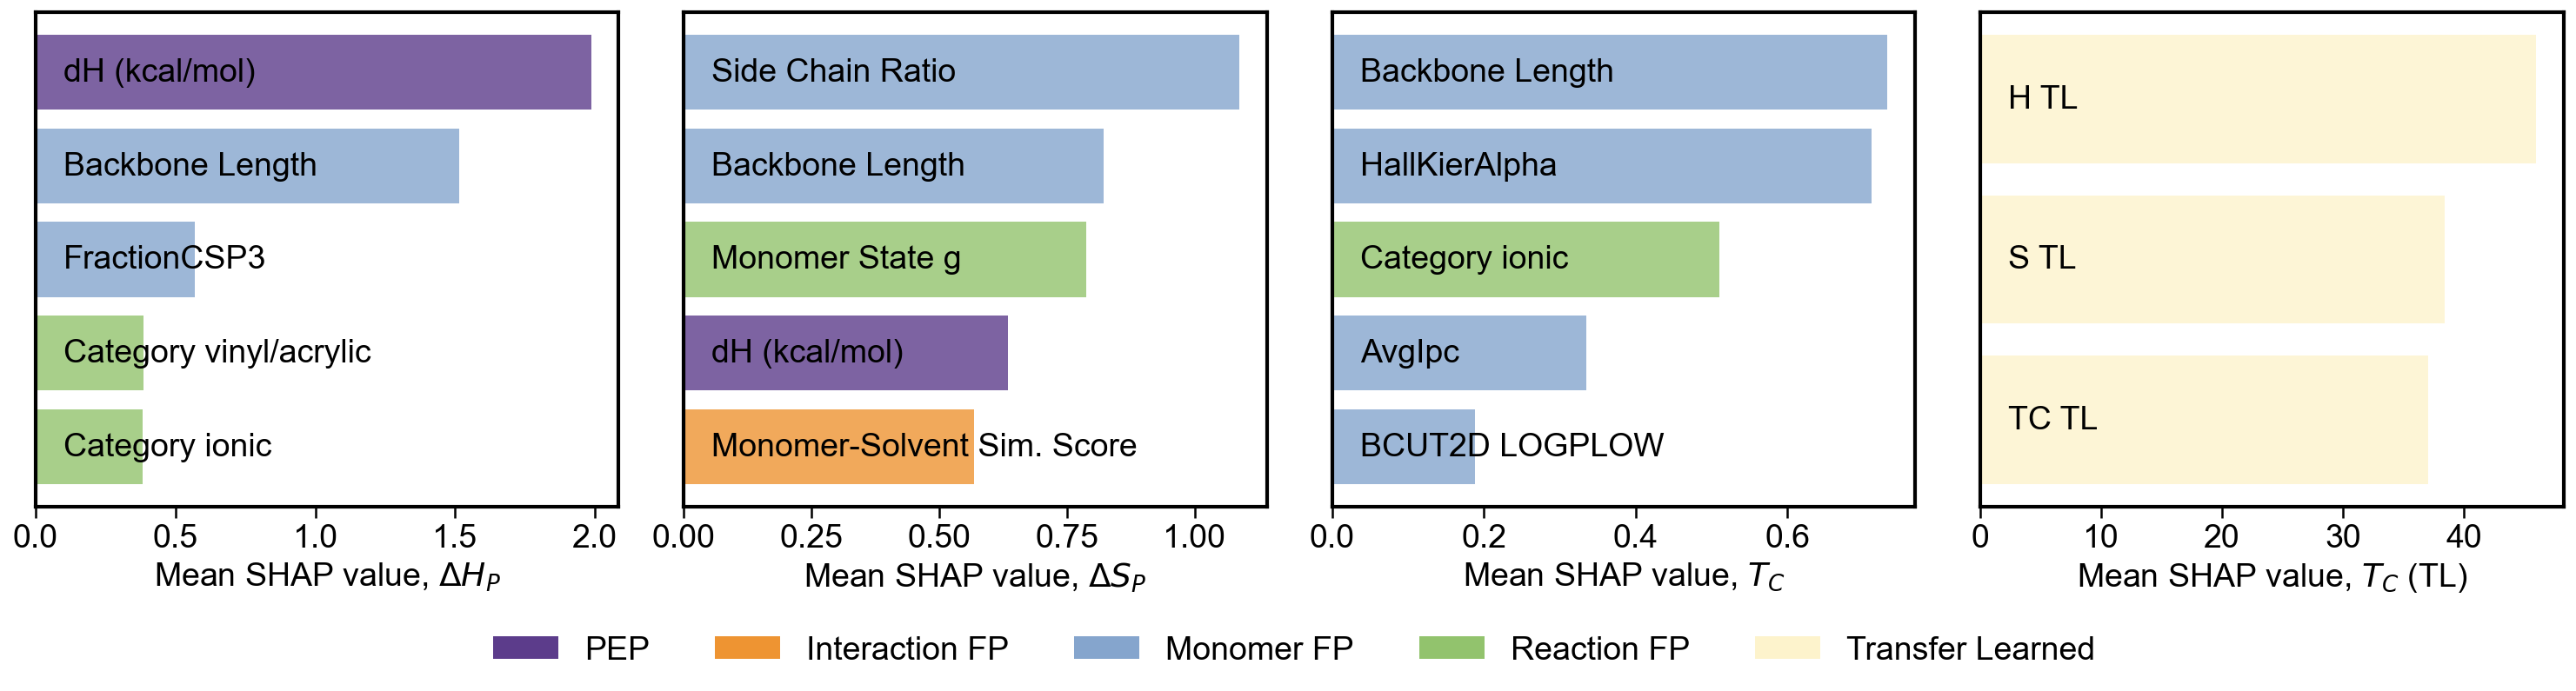

In [182]:
prefix_dict = {
    'PEP': ("#5c3c8b", ['PEP_']),
    'Interaction FP': ("#ee9432", ['MIX_', 'TANIMOTO']),
    'Monomer FP': ("#85a5cd", []), # default
    'Reaction FP': ("#92c36d", ['BASE_']),
    'Transfer Learned': ("#FDF3CC", ['predicted_']),
}

labeldict = {'enthalpy': '$\\Delta H_P$',
 'entropy': '$\\Delta S_P$',
 'tc': '$T_C$',
 'log_tc': '$T_C$ (log)',
 'tc_indirect': '$T_C$ (Eqn.)',
 'tc_transfer': '$T_C$ (TL)'}


def get_feature_color(feature_name, prefix_dict):
    """Return color for feature based on prefix matching"""
    for category, (color, prefixes) in prefix_dict.items():
        for prefix in prefixes:
            if feature_name.startswith(prefix):
                return color
    return prefix_dict['Monomer FP'][0]

ps = ['enthalpy', 'entropy', 'tc', 'tc_transfer']
fig, axes = plt.subplots(1, len(ps), figsize=(plotsize*len(ps), plotsize), sharey=False)
for ax, target in zip(axes, ps):
    df_feat = feature_info[target]
    X = df_feat[df_feat['Global_Test'] == False].iloc[:, first_feature_idx:]
    X = X.astype(float)

    model = best_models[target]
    explainer = shap.Explainer(model.predict, X[model.feature_names_in_])
    shap_values = explainer(X[model.feature_names_in_])
    importances = np.abs(shap_values.values).mean(axis=0)
    feature_names = model.feature_names_in_
    top_idx = np.argsort(importances)[-5:][::-1]
    top_features = feature_names[top_idx]
    top_importances = importances[top_idx]
    
    colors = [get_feature_color(feature, prefix_dict) for feature in top_features[::-1]]
    
    bars = ax.barh(top_features[::-1], top_importances[::-1], color=colors, alpha=0.8)

    ax.set_xlabel(rf"Mean SHAP value, {labeldict[target]}")
    ax.set_yticklabels([])
    
    ax.tick_params(axis='y', which='major', width=0)

    largest_bar_w = 0
    for bar, label in zip(bars, top_features[::-1]):
        w = bar.get_width()
        if w > largest_bar_w:
            largest_bar_w = w

    for bar, label in zip(bars, top_features[::-1]):
        try:
            newlabel = label.split('_', 1)[1].replace('_', ' ')
        except:
            newlabel = label.replace('_', ' ').title()

        if newlabel == 'Tanimoto':
            newlabel = 'Monomer-Solvent Sim. Score'
    
        ax.text(largest_bar_w/20, bar.get_y() + bar.get_height()/2, newlabel,
                va='center', ha='left', color='black')

legend_elements = []
for category, (color, prefixes) in prefix_dict.items():
    clean_label = category.replace('_', ' ')
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color, label=clean_label))

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=len(legend_elements))


plt.tight_layout()
plt.savefig(f"{output_dir}/global_shap_importances.png", dpi=300)
plt.show()

### Look deeper at errors: inherent model uncertainty
For SVR (S) and RF (H)

  Train samples: 455, Test samples: 29
  Train samples: 323, Test samples: 29


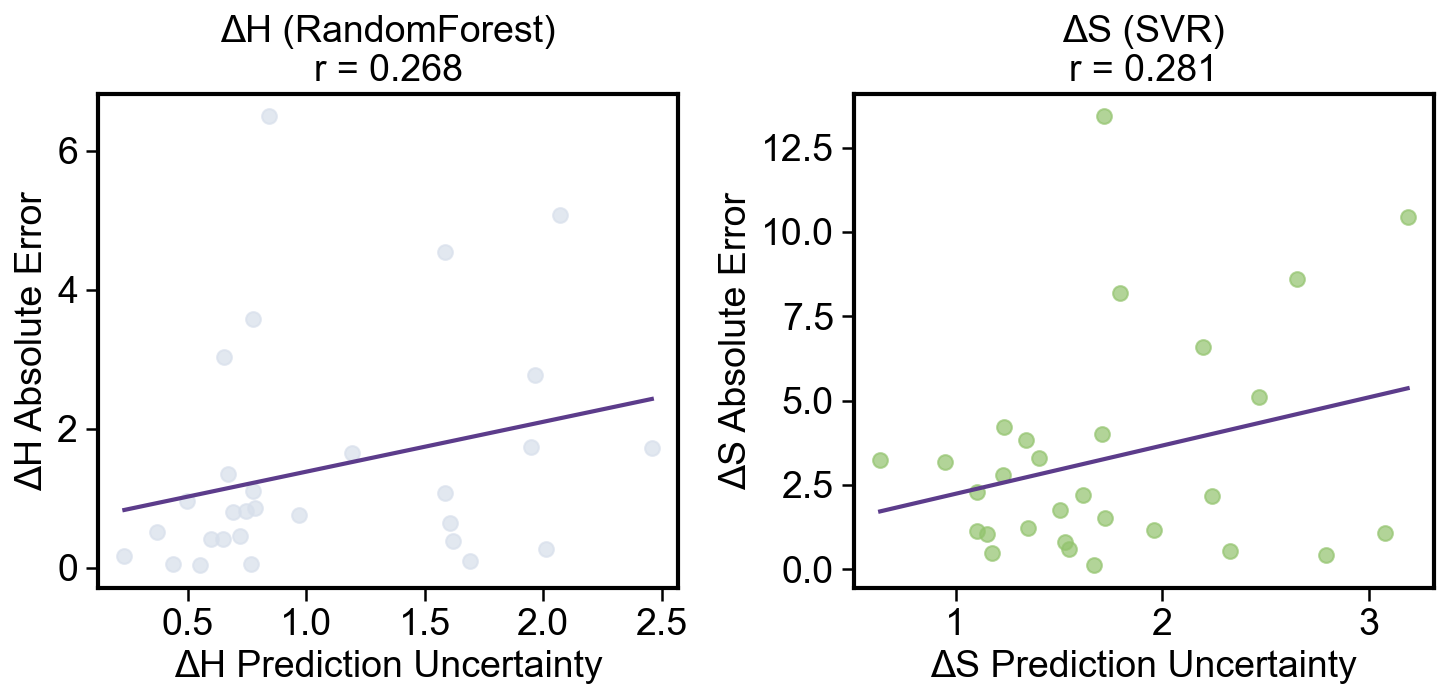

In [77]:
def detect_model_type(model):
    # If it's a pipeline, get the final estimator
    if isinstance(model, Pipeline):
        final_model = model.steps[-1][1]
    else:
        final_model = model
    
    # Check model type
    if isinstance(final_model, GaussianProcessRegressor):
        return 'GPR'
    elif isinstance(final_model, KernelRidge):
        return 'KRR'
    elif isinstance(final_model, (RandomForestRegressor,)):
        return 'RandomForest'
    elif isinstance(final_model, SVR):
        return 'SVR'
    else:
        return type(final_model).__name__

def get_ensemble_uncertainty_bootstrap(model, X_train, y_train, X_test, y_test, n_bootstrap=100):
    predictions = []
        
    for i in range(n_bootstrap):
        # Bootstrap sample training data
        X_boot, y_boot = resample(X_train, y_train, random_state=i)
        
        model_boot = clone(model)
        model_boot.fit(X_boot, y_boot)
        
        pred = model_boot.predict(X_test)
        predictions.append(pred)
        
    # Calculate uncertainty from ensemble
    predictions = np.array(predictions)
    y_pred_mean = np.mean(predictions, axis=0)
    y_pred_std = np.std(predictions, axis=0)
    abs_error = np.abs(y_pred_mean - y_test)
    
    return y_pred_mean, y_pred_std, abs_error

def get_gpr_uncertainty(model, X_test, y_test):
    """Get uncertainty estimates from Gaussian Process Regressor"""
    if isinstance(model, Pipeline):
        final_model = model.steps[-1][1]
        X_transformed = X_test
        for name, transformer in model.steps[:-1]:
            X_transformed = transformer.transform(X_transformed)
        y_pred, y_std = final_model.predict(X_transformed, return_std=True)
    else:
        y_pred, y_std = model.predict(X_test, return_std=True)
    
    abs_error = np.abs(y_pred - y_test)
    return y_pred, y_std, abs_error

def get_uncertainty_for_model(model, X_train, y_train, X_test, y_test, n_bootstrap=100):
    model_type = detect_model_type(model)
        
    if model_type == 'GPR':
        return get_gpr_uncertainty(model, X_test, y_test) + (model_type,)
    else:
        return get_ensemble_uncertainty_bootstrap(
            model, X_train, y_train, X_test, y_test, n_bootstrap
        ) + (model_type,)

def prepare_test_data(feature_info, target_name, first_feature_idx, target_idx):
    df = feature_info[target_name].copy()
    
    test_mask = df['Global_Test'] == True
    X_test = df[test_mask].iloc[:, first_feature_idx:].astype(float)
    y_test = df[test_mask].iloc[:, target_idx].values
    
    train_mask = df['Global_Test'] == False
    X_train = df[train_mask].iloc[:, first_feature_idx:].astype(float)
    y_train = df[train_mask].iloc[:, target_idx].values
    
    return X_train, X_test, y_train, y_test

config = {
    'enthalpy': {'first_feature_idx': 4, 'target_idx': 0},
    'entropy': {'first_feature_idx': 4, 'target_idx': 0}
}

uncertainty_results = {}

for property_name in ['enthalpy', 'entropy']:
    if property_name not in best_models:
        continue
        
    cfg = config[property_name]
    X_train, X_test, y_train, y_test = prepare_test_data(
        feature_info, 
        property_name, 
        first_feature_idx=cfg['first_feature_idx'], 
        target_idx=cfg['target_idx']
    )
    
    print(f"  Train samples: {len(y_train)}, Test samples: {len(y_test)}")
    
    model = best_models[property_name]
    y_pred, y_std, abs_error, model_type = get_uncertainty_for_model(
        model, X_train, y_train, X_test, y_test, n_bootstrap=50  # Reduced for speed
    )
    
    uncertainty_results[property_name] = {
        'predictions': y_pred,
        'uncertainty': y_std, 
        'abs_error': abs_error,
        'actual': y_test,
        'model_type': model_type
    }

colors = {
    'enthalpy': fg_colors['alcohol'],
    'entropy': fg_colors['amine']
}

fig, axes = plt.subplots(1, 2, figsize=(plotsize*2, plotsize))

properties = ['enthalpy', 'entropy']
labels = ['ΔH', 'ΔS']
colors = [fg_colors['alcohol'], fg_colors['amine'], fg_colors['carbonyl']]

for i, (prop, label, color) in enumerate(zip(properties, labels, colors)):
    if prop not in uncertainty_results:
        continue
        
    ax = axes[i]
    data = uncertainty_results[prop]
    
    scatter = ax.scatter(
        data['uncertainty'], 
        data['abs_error'],
        alpha=0.7,
        color=color,
        s=50,
    )
    
    correlation = np.corrcoef(data['uncertainty'], data['abs_error'])[0, 1]
    
    z = np.polyfit(data['uncertainty'], data['abs_error'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(data['uncertainty'].min(), data['uncertainty'].max(), 100)
    ax.plot(x_line, p(x_line))
    
    ax.set_xlabel(f'{label} Prediction Uncertainty')
    ax.set_ylabel(f'{label} Absolute Error')
    ax.set_title(f'{label} ({data["model_type"]})\nr = {correlation:.3f}')

plt.tight_layout()

plt.savefig(f"{output_dir}/uncertainty_vs_error_H_and_S.png", dpi=300, bbox_inches='tight')
plt.show()

for prop, label in zip(properties, labels):
    if prop not in uncertainty_results:
        continue
    data = uncertainty_results[prop]
    correlation = np.corrcoef(data['uncertainty'], data['abs_error'])[0, 1]
    r2 = r2_score(data['actual'], data['predictions'])
    mae = mean_absolute_error(data['actual'], data['predictions'])
    z = np.polyfit(data['uncertainty'], data['abs_error'], 1)

### Model uncertainty Contour

In [129]:
# reread overlap without dropping H and S
filename = "0_raw_data_sets/2_global_test_flagged_data.csv"
df = pd.read_csv(filename, index_col=0).dropna(subset=['dH (kcal/mol)', 'dS (cal/mol/K)'])
df['Tc (K)'] = df['dH (kcal/mol)']*1000/df['dS (cal/mol/K)'] # K

one_hot_encoding = pd.get_dummies(df[['BASE_Category', 'BASE_Monomer_State']])

df = pd.concat([df, one_hot_encoding], axis=1)

H_values = df['dH (kcal/mol)']
S_values = df['dS (cal/mol/K)']

H_features = df[best_models['enthalpy'].feature_names_in_.tolist()]
S_features = df[best_models['entropy'].feature_names_in_.tolist()]

H_training_features = feature_sets[0][1].iloc[:, first_feature_idx:]
H_training_targets = feature_sets[0][1].iloc[:, target_idx]

S_training_features = feature_sets[1][1].iloc[:, first_feature_idx:]
S_training_targets = feature_sets[1][1].iloc[:, target_idx]

/var/folders/ss/dmsyhg291_ldxc23t146pcq40000gn/T/ipykernel_39060/3346109670.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(tick_labels)


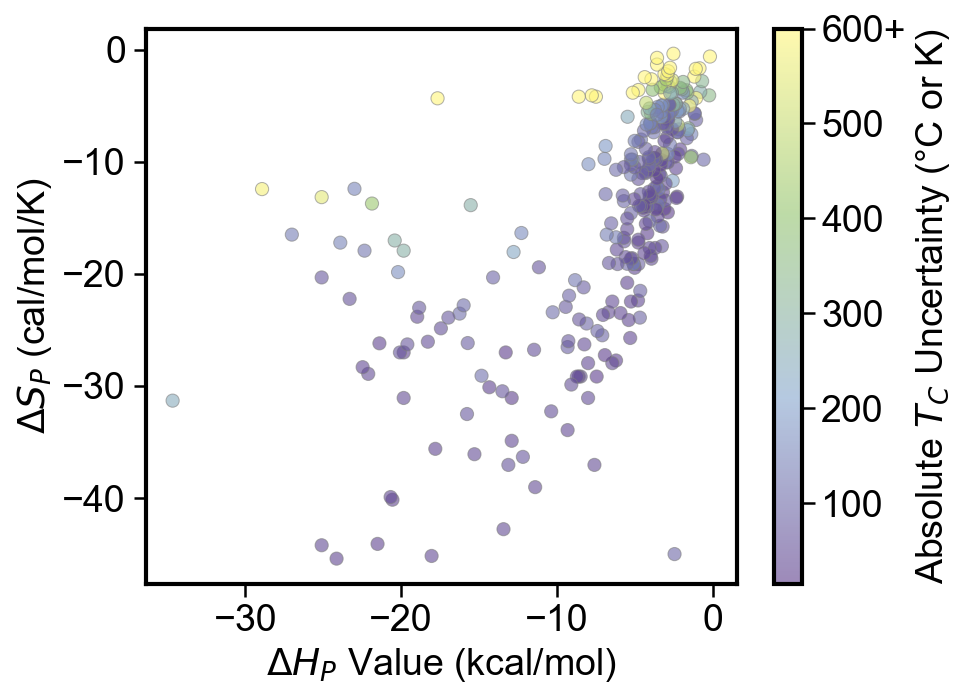

In [ ]:
def create_uncertainty_contour(H_values, S_values, H_features, S_features, 
                              enthalpy_model, entropy_model, H_train_features, H_train_targets,
                              S_train_features, S_train_targets):
    
    combined_uncertainties = []
    
    # Loop through each data point
    for i in range(len(H_values)):
        H_val = H_values.iloc[i]
        S_val = S_values.iloc[i]

        if H_val > 0 or S_val > 0:
            combined_uncertainties.append(np.nan)
            continue
    
        H_result = get_uncertainty_for_model(
            enthalpy_model, 
            H_train_features, 
            H_train_targets, 
            H_features.iloc[i:i+1],  # X_test
            H_values.iloc[i:i+1],      # y_test
            n_bootstrap=20
        )
        
        S_result = get_uncertainty_for_model(
            entropy_model, 
            S_train_features, 
            S_train_targets, 
            S_features.iloc[i:i+1],   # X_test
            S_values.iloc[i:i+1],      # y_test
            n_bootstrap=20
        )
        
        unc_H = H_result[1]
        unc_S = S_result[1]
        
        if isinstance(unc_H, (list, np.ndarray)):
            unc_H = unc_H[0]
        if isinstance(unc_S, (list, np.ndarray)):
            unc_S = unc_S[0]
        
        if H_val != 0 and S_val != 0 and not np.isnan(unc_H) and not np.isnan(unc_S):
            T = H_val * 1000 / S_val # K
            combined_unc = T * np.sqrt((unc_H / H_val) ** 2 + (unc_S / S_val) ** 2)
        else:
            combined_unc = np.nan
        
        combined_uncertainties.append(combined_unc)
    
    combined_uncertainties = np.array(combined_uncertainties)
    uncmax = 600
    combined_uncertainties[combined_uncertainties > uncmax] = uncmax
    combined_uncertainties[combined_uncertainties < -uncmax] = -uncmax
    
    plt.figure(figsize=(plotsize*1.35, plotsize))

    scat = plt.scatter(
        H_values, 
        S_values, 
        c=combined_uncertainties, 
        cmap=pos_colormap, 
        edgecolor='gray', 
        linewidth=0.5,
        s=40,
        alpha=0.6
    )
    
    cbar = plt.colorbar(scat)
    tick_labels = [f"{int(tick)}" + ("+" if abs(tick) == uncmax else "") for tick in cbar.get_ticks()]
    cbar.ax.set_yticklabels(tick_labels)
    cbar.set_label(r'Absolute $T_C$ Uncertainty (°C or K)')
    
    plt.xlabel(r'$\Delta H_P$ Value (kcal/mol)')
    plt.ylabel(r'$\Delta S_P$ (cal/mol/K)')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/tc_design_space_model_uncertainties.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return combined_uncertainties

uncertainties = create_uncertainty_contour(
    H_values=H_values,
    S_values=S_values, 
    H_features=H_features,
    S_features=S_features,
    enthalpy_model=best_models['enthalpy'],
    entropy_model=best_models['entropy'],
    H_train_features=H_training_features,
    H_train_targets=H_training_targets,
    S_train_features=S_training_features, 
    S_train_targets=S_training_targets
)